In [4]:
from core import *
import os , random

directory = '/home/mmed/Documents/projects/bill_reader/data'
bill = random.choice(os.listdir(directory))
file =os.path.join(directory, bill)
# file = '/home/mmed/Documents/projects/bill_reader/data/dennys-20190420_009.pdf'
# file = '/home/mmed/Documents/projects/bill_reader/data/applebees_8267120140431.pdf'

In [2]:
fig_size = plt.rcParams["figure.figsize"]

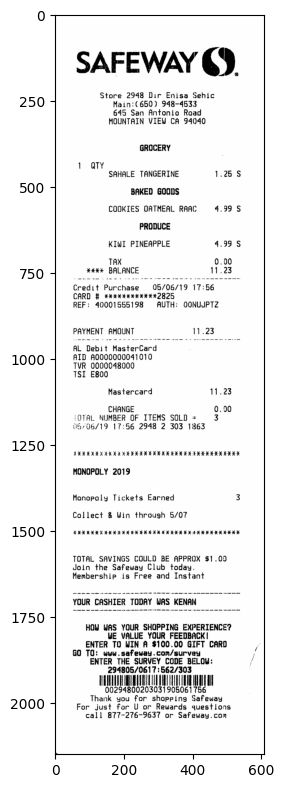

In [5]:
plt.rcParams["figure.figsize"] = [2 * x for x in fig_size]
image = get_image(file)
plt.imshow(image)
plt.show()

In [6]:
results = ts.image_to_data(image, 
output_type=Output.DICT)
df = pd.DataFrame(data= results)
df = df[df.text != '']
df = df.apply(clean_the_text,axis= 1)

In [7]:
cnt = 0
for i,row in df.iterrows():
   x = df['left'][i]
   y = df["top"][i]

   w = df["width"][i]
   h = df["height"][i]

   text = df["text"][i] 
   conf = int(df["conf"][i])

   if isprice(text):
        cnt+=1
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, text, (x, y - 10), 
cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)
print(cnt)

10


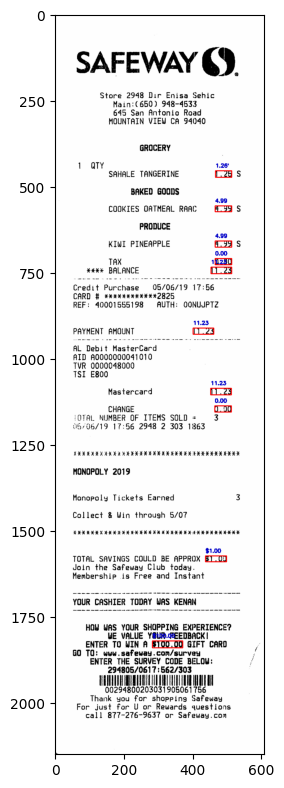

In [8]:
plt.imshow(image)
plt.show()

In [ ]:
text = ts.image_to_string(image)
print(text)

In [9]:
product_lines = {}
prices = df[df['text'].apply(isprice)]
for x in prices.top.values:
    product_lines[x] = []
for ind,row in df.iterrows():
    for line in product_lines:
        if same_line(row.top,line) :
            product_lines[line].append(row.text)
    for line in product_lines:
        merge_names(product_lines[line])

In [10]:
product_lines

{455: ['SAHALE TANGERINE', "1.26'", 'S'],
 557: ['COOKIES ORTMEAL RAAC', '4.99', 'S'],
 659: ['KIWI PINEAPPLE', '4.99', 'S'],
 710: ['TAX', '0.00'],
 735: ['*#% BALANCE', '11.23'],
 912: ['PAYMENT AMOUNT', '11.23'],
 1087: ['Mastercard', '11.23'],
 1138: ['CHANGE', '0.00'],
 1574: ['TOTAL SAVINGS COULD BE APPROX', '$1.00'],
 1821: ['ENTER TO WIN A', '$100.00', 'GIFT CARD']}

In [13]:
def most_frequent(List):
    counter = 0
    num = List[0]
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
    return num

def isolate_products(product_lines):
    lines =[]
    last_line = -1
    distances = []
    for line in product_lines:
        lines.append(line)
        if last_line == -1:
            last_line = line
            continue
        distances.append(line - last_line)
        last_line = line
    step = most_frequent(distances)
    for ind in range(len(lines)):
        neighbours_count = 0
        if ind != 0 :
            if lines[ind] - lines[ind-1] < step + 10 :
                neighbours_count +=1
        if ind!=len(lines)-1 :
            if lines[ind+1] - lines[ind] < step + 10 :
                neighbours_count +=1
        if neighbours_count==0:
            product_lines.pop(lines[ind])
    

In [12]:
isolate_products(product_lines)
product_lines

{455: ['SAHALE TANGERINE', "1.26'", 'S'],
 557: ['COOKIES ORTMEAL RAAC', '4.99', 'S'],
 659: ['KIWI PINEAPPLE', '4.99', 'S'],
 710: ['TAX', '0.00'],
 735: ['*#% BALANCE', '11.23'],
 1087: ['Mastercard', '11.23'],
 1138: ['CHANGE', '0.00']}

In [14]:
def get_match(element):
    if element.isdigit():
        return "quantity"
    elif isprice(element):
        return "price"
    else:
        return "desc"


def get_format(line):
    line_format = []
    for element in line:
        if element.isdigit():
            if line_format.count("quantity") >= 1:
                continue
            line_format.append("quantity")
        elif isprice(element):
            if line_format.count("price") >= 2:
                continue
            line_format.append("price")
        else:
            if line_format.count("desc") >= 1:
                continue
            line_format.append("desc")
    return line_format


def follow_format(line, line_format):
    line_index = 0
    format_index = 0
    while line_index < len(line) and format_index < len(line_format):
        if get_match(line[line_index]) == line_format[format_index]:
            line_index += 1
            format_index += 1
        else:
            line_index += 1
    return format_index == len(line_format)


def get_data(line, line_format):
    line_index = 0
    format_index = 0
    row = []
    while line_index < len(line) and format_index < len(line_format):
        if get_match(line[line_index]) == line_format[format_index]:
            row.append(line[line_index])
            line_index += 1
            format_index += 1
        else:
            line_index += 1
    return row

In [15]:
formats = []
for line in product_lines:
    formats.append(get_format(product_lines[line]))
print(most_frequent(formats))

['desc', 'price']


In [16]:
formats = []
for line in product_lines:
    formats.append(get_format(product_lines[line]))
chosen_format = most_frequent(formats)
product_list = pd.DataFrame(columns=chosen_format)
for line in product_lines:
    if follow_format(product_lines[line],chosen_format):
        product_list.loc[len(product_list.index)] = get_data(product_lines[line],chosen_format)
product_list


,desc,price
0,SAHALE TANGERINE,1.26'
1,COOKIES ORTMEAL RAAC,4.99
2,KIWI PINEAPPLE,4.99
3,TAX,0.00
4,*#% BALANCE,11.23
5,Mastercard,11.23
6,CHANGE,0.00


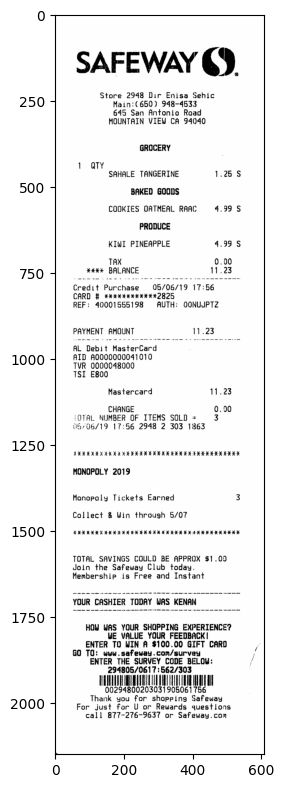

In [17]:
plt.rcParams["figure.figsize"] = [ 2 * x for x in fig_size]
image = get_image(file)
plt.imshow(image)
plt.show()